**INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [21]:
#@ IMPORTING NECESSARY LIBRARIES AND DEPENDENCIES: 
from torchvision.models import detection
from imutils.video import VideoStream
from imutils.video import FPS
import imutils
import time
import numpy as np
import cv2
import pickle
import torch
from google.colab.patches import cv2_imshow

**COCO DATASET:**
- The [**COCO Dataset**](https://cocodataset.org/#home): Common Objects in Context, tends to be the standard for object detection benchmarking. The dataset contains over *90 classes* of common objects we will see in everyday world. 

In [3]:
#@ INITIALIZING DATASET AND DEPENDENCIES: 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")    # Initializing GPU. 
CLASSES = pickle.loads(open("./coco_classes.pickle", "rb").read())       # Initializing COCO labels. 
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))               # Initializing Colors. 

**OBJECT DETECTION:**
- Object Detection is a computer technology related to computer vision and image processing that deals with detecting instances of semantic objects of a certain class. I will use PyTorch to perform object detection using the following state-of-the-art classification networks:
    - Faster R-CNN with a ResNet50.
    - Faster R-CNN with a MobileNet V3.
    - RetinaNet with a ResNet50. 


In [5]:
#@ INITIALIZING OBJECT DETECTION MODELS: 
MODELS = {
    "frcnn-resnet": detection.fasterrcnn_resnet50_fpn,                         # Faster R-CNN with a ResNet50. 
    "frcnn-mobilenet": detection.fasterrcnn_mobilenet_v3_large_320_fpn,        # Faster R-CNN with a MobileNet V3. 
    "retinanet": detection.retinanet_resnet50_fpn}                             # RetinaNet with a ResNet50. 
model = MODELS["frcnn-resnet"](pretrained=True, progress=True,                 # Initializing pretrained weights. 
                               num_classes=len(CLASSES),                       # Total number of classes. 
                               pretrained_backbone=True).to(DEVICE)            # Initializing backbone networks. 
model.eval();                                                                  # Evaluation mode. 

**IMAGE PREPROCESSING:**
- Converting color channel ordering from BGR to RGB. 
- Swapping color channel ordering from *channels last* to *channels first*. 
- Adding a batch dimension. 
- Scaling pixel intensities from the range *\[0, 255]* to *\[0, 1]*. 
- Converting the image from a numpy array to a floating point tensor. 

In [19]:
#@ INITIALIZING IMAGE PREPROCESSING: 
image = cv2.imread("./F9.jpg")                      # Loading the image. 
orig = image.copy()                                 # Copying the image. 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)      # Converting image into RGB. 
image = image.transpose((2, 0, 1))                  # Initializing channel first ordering. 
image = np.expand_dims(image, axis=0)               # Adding batch dimension. 
image = image / 255.0                               # Normalizing the image. 
image = torch.FloatTensor(image)                    # Converting into float tensor. 
image = image.to(DEVICE)
detections = model(image)[0]                        # Getting predictions. 

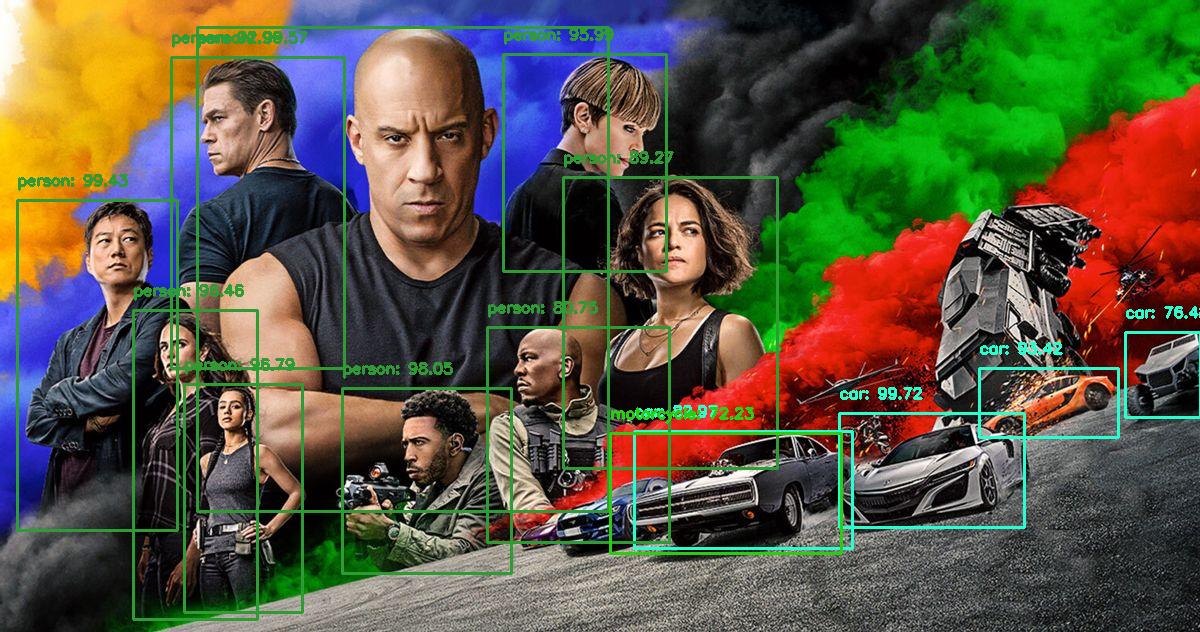

In [20]:
#@ INITIALIZING BOUNDING BOXES PREDICTIONS: 
for i in range(0, len(detections["boxes"])):
    confidence = detections["scores"][i]                        # Extracting probabilities. 
    if confidence > 0.7:
        idx = int(detections["labels"][i])                      # Extracting index. 
        box = detections["boxes"][i].detach().cpu().numpy()
        (startX, startY, endX, endY) = box.astype("int")        # Computing coordinates. 
        label="{}: {:.2f}".format(CLASSES[idx],confidence*100)
        cv2.rectangle(orig, (startX, startY), (endX, endY), 
                      COLORS[idx], 2)                           # Drawing rectangle. 
        y = startY - 15 if startY - 15 > 15 else startY + 15
        cv2.putText(orig, label, (startX, y), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, 
                    COLORS[idx], 2)                             # Putting text. 

#@ INSPECTING OUTPUT IMAGE:
cv2_imshow(orig)

**REALTIME OBJECT DETECTION:**

In [69]:
#@ INITIALIZING VIDEO STREAM:
vs = VideoStream("./F9.mp4").start()            # Starting video stream. 
fps = FPS().start()                             # Approximate frames per second. 

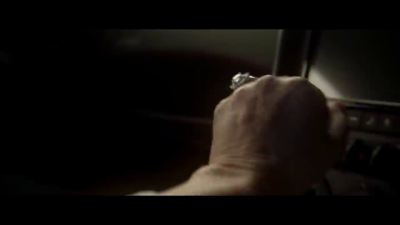

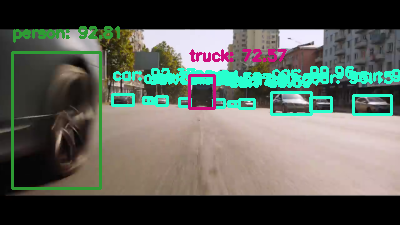

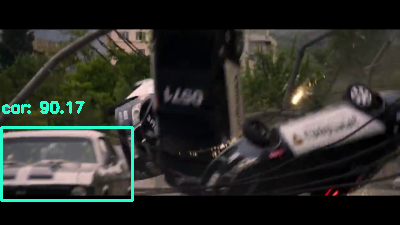

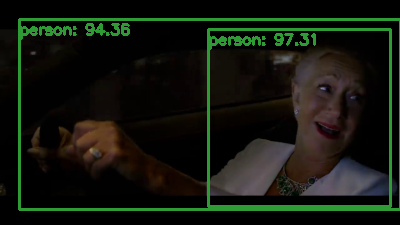

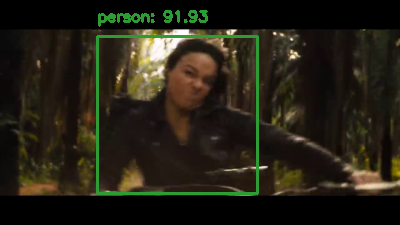

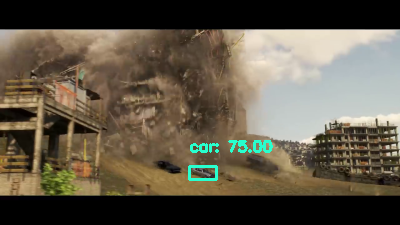

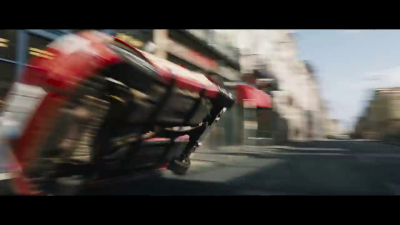

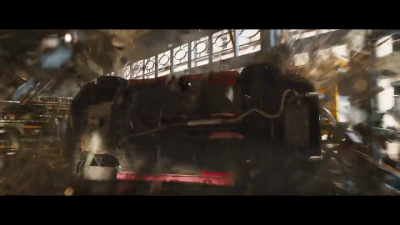

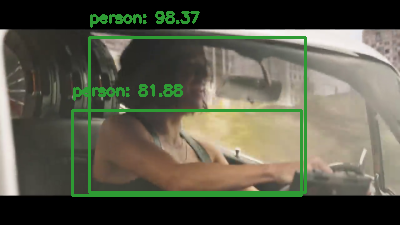

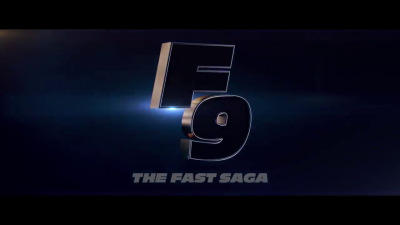

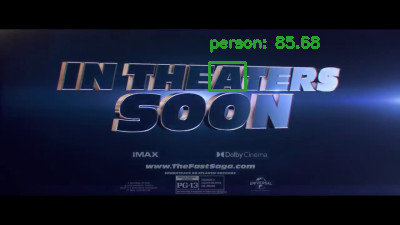

Elapsed time: 11.94
FPS: 0.92


In [70]:
#@ INITIALIZING LOOP OVER FRAMES:
while True:
    frame = vs.read()                               # Grabbing a frame.
    if frame is None: break  
    frame = imutils.resize(frame, width=400)        # Resizing the frame. 
    orig = frame.copy()                             # Copying the frame. 
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Converting to RGB channel. 
    frame = frame.transpose((2, 0, 1))              # Initializing channel first ordering.
    frame = np.expand_dims(frame, axis=0)           # Adding batch dimension. 
    frame = frame / 255.0                           # Normalizing the frame. 
    frame = torch.FloatTensor(frame)                # Converting into float tensor. 
    frame = frame.to(DEVICE)
    detections = model(frame)[0]                    # Getting predictions. 
    #@ INITIALIZING BOUNDING BOXES PREDICTIONS: 
    for i in range(0, len(detections["boxes"])):
        confidence = detections["scores"][i]                        # Extracting probabilities. 
        if confidence > 0.7:
            idx = int(detections["labels"][i])                      # Extracting index. 
            box = detections["boxes"][i].detach().cpu().numpy()
            (startX, startY, endX, endY) = box.astype("int")        # Computing coordinates. 
            label="{}: {:.2f}".format(CLASSES[idx],confidence*100)
            cv2.rectangle(orig, (startX, startY), (endX, endY), 
                        COLORS[idx], 2)                             # Drawing rectangle. 
            y = startY - 15 if startY - 15 > 15 else startY + 15
            cv2.putText(orig, label, (startX, y), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, 
                        COLORS[idx], 2)                             # Putting text. 
    #@ INSPECTING OUTPUT:
    cv2_imshow(orig)
    fps.update()
#@ INITIALIZING FPS INFORMATION:
fps.stop()
print("Elapsed time: {:.2f}".format(fps.elapsed()))
print("FPS: {:.2f}".format(fps.fps()))
vs.stop()